In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "poultry",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5596 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names
class_names

['cocii', 'healthy', 'ncd', 'salmo']

In [5]:
len(dataset)

175

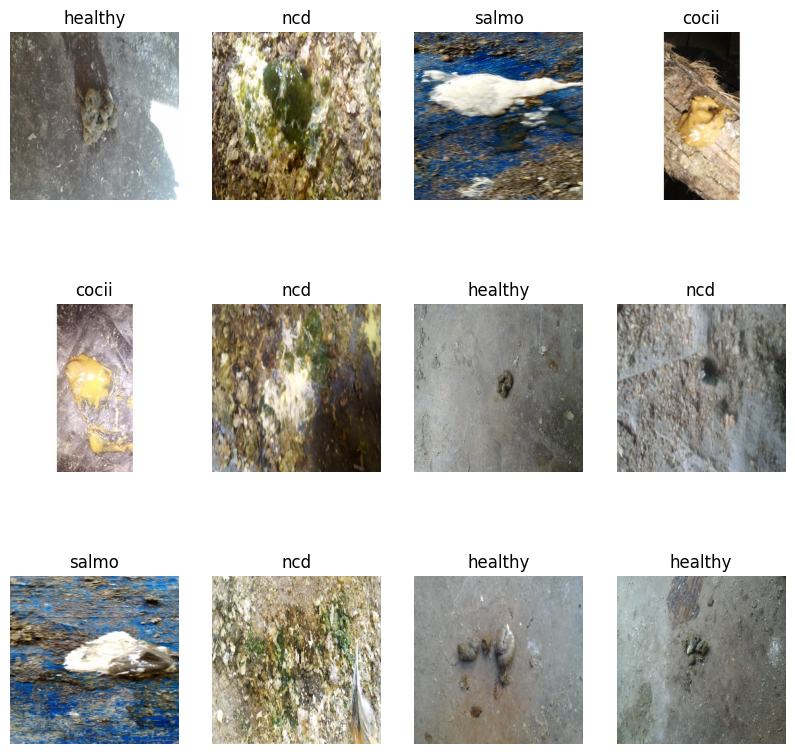

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_size=0.8
len(dataset)*train_size

140.0

In [8]:
train_ds=dataset.take(140)
len(train_ds)

140

In [9]:
test_ds=dataset.skip(140)
len(test_ds)

35

In [10]:
val_size=0.1
len(dataset)*val_size

17.5

In [11]:
val_ds=test_ds.take(17)
len(val_ds)

17

In [12]:
test_ds=test_ds.skip(17)
len(test_ds)

18

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

140

In [16]:
len(val_ds)

17

In [17]:
len(test_ds)

18

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
 76/140 [===============>..............] - ETA: 3:01 - loss: 1.0424 - accuracy: 0.5540

## scores = model.evaluate(test_ds)

In [27]:
scores

[0.1615011841058731, 0.9370629191398621]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 140}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.7169347405433655,
 0.8322162628173828,
 0.8746649026870728,
 0.8983467221260071,
 0.9041554927825928,
 0.9220286011695862,
 0.9121983647346497,
 0.9197944402694702,
 0.923815906047821,
 0.9309651255607605]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Trainig and Validation Loss')

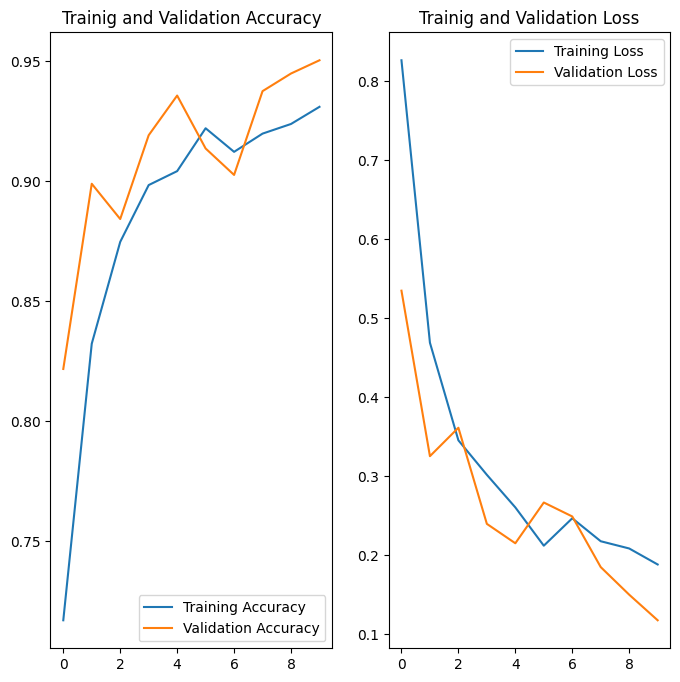

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trainig and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Trainig and Validation Loss')

first image to predict
first image's actual label: healthy
1/1 [==============================] - 1s 637ms/step
predicted label: salmo


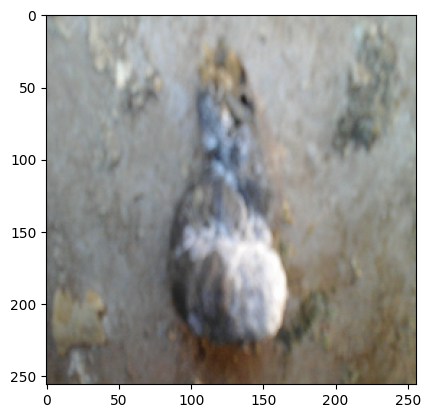

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction= model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)  #create batch

    predictions= model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 78ms/step


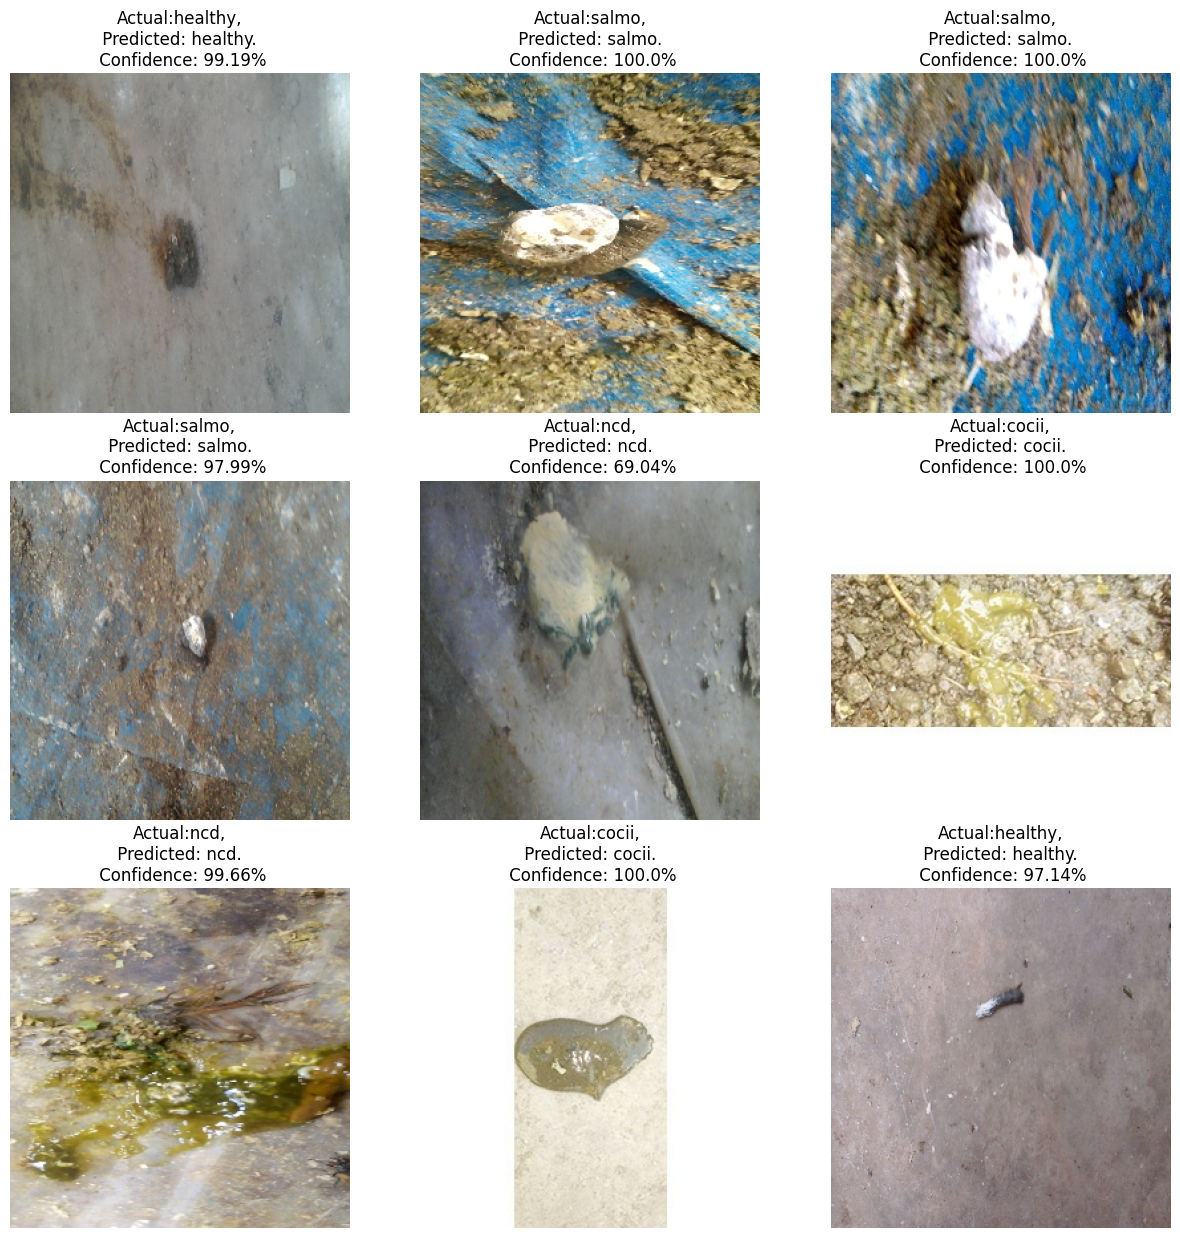

In [51]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")

In [52]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
